# Convolutional Autoencoder solution


In [1]:
# public modules
from dlcliche.notebook import *
from dlcliche.utils import (
    sys, random, Path, np, plt, EasyDict,
    ensure_folder, deterministic_everything,
)
from argparse import Namespace

# private modules
sys.path.append('..')
import common as com

from image_common import *
from model import CNNAutoEncoder

# loading parameters -> hparams (argparse compatible)
params = EasyDict(com.yaml_load('config.yaml'))

# create working directory
ensure_folder(params.model_directory)

# test targets
if 'target' in params:
    types = params.target
else:
    types = [d.name for d in Path(params.dev_directory).glob('*') if d.is_dir()]

# dataset
data_files = sorted(Path(params.dev_directory).glob('dc2020t2l1*.npy'))
data = {t:[f for f in data_files if t in str(f)] for t in types}

# fix random seeds
deterministic_everything(2020, pytorch=True)

# PyTorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
data

{'ToyConveyor': [PosixPath('../dev_data/dc2020t2l1-ToyConveyor-test.npy'),
  PosixPath('../dev_data/dc2020t2l1-ToyConveyor-train.npy')],
 'ToyCar': [PosixPath('../dev_data/dc2020t2l1-ToyCar-test.npy'),
  PosixPath('../dev_data/dc2020t2l1-ToyCar-train.npy')],
 'slider': [PosixPath('../dev_data/dc2020t2l1-slider-test.npy'),
  PosixPath('../dev_data/dc2020t2l1-slider-train.npy')],
 'fan': [PosixPath('../dev_data/dc2020t2l1-fan-test.npy'),
  PosixPath('../dev_data/dc2020t2l1-fan-train.npy')],
 'pump': [PosixPath('../dev_data/dc2020t2l1-pump-test.npy'),
  PosixPath('../dev_data/dc2020t2l1-pump-train.npy')],
 'valve': [PosixPath('../dev_data/dc2020t2l1-valve-test.npy'),
  PosixPath('../dev_data/dc2020t2l1-valve-train.npy')]}

In [3]:
types

['ToyConveyor', 'ToyCar', 'slider', 'fan', 'pump', 'valve']

### Testing dataset class *if using albumentations*

**NOTE: We are not using augmentation in this example**

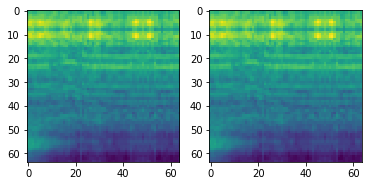

In [4]:
if True: # test dataset
    from albumentations import (
        HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, RandomCrop,
        Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
        IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
        IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose,
        ISONoise, Cutout
    )

    class MyTfm():
        def __init__(self):
            self.album_tfm = Compose([
                Cutout(num_holes=8, max_h_size=6, max_w_size=6, p=0.6),
                ShiftScaleRotate(shift_limit=0.3, scale_limit=0.1, rotate_limit=0, p=.5),
            ], p=1)
        def __call__(self, x):        
            data = {"image": x}
            augmented = self.album_tfm(**data)
            x = augmented["image"]
            return x

    trn_ds = Task2ImageDataset(data[types[0]][1], augment_tfm=MyTfm(), aug_y=True, random=True)
    train_index = trn_ds.get_index_by_pct()
    trn_ds.train_split(train_index)
    fig, ax = plt.subplots(1, 2)
    one = trn_ds[0]; ax[0].imshow(one[0]); ax[1].imshow(one[1]);

In [5]:
class Task2ImageLightning(Task2Lightning):
    """Task2 PyTorch Lightning class, for training only."""

    def __init__(self, device, model, params, preprocessed_file, normalize=True):
        super().__init__(device, model, params, files=None, normalize=normalize)
        self.device = device
        self.params = params
        self.normalize = normalize
        self.model = model
        self.mseloss = torch.nn.MSELoss()

        to_tensor = ToTensor1ch(device=self.device, image=True)
        self.trn_ds = Task2ImageDataset(preprocessed_file, transform=to_tensor,
                                      normalize=normalize)
        self.val_ds = Task2ImageDataset(preprocessed_file, transform=to_tensor,
                                      normalize=normalize, random=False)
        train_index = self.trn_ds.get_index_by_pct()
        self.trn_ds.train_split(train_index)
        self.val_ds.val_split(train_index)

    def _get_dl(self, for_what):
        ds = self.trn_ds if for_what == 'train' else self.val_ds
        return torch.utils.data.DataLoader(ds, batch_size=self.params.fit.batch_size,
                          shuffle=(self.params.fit.shuffle if for_what == 'train' else False))

In [6]:
# train models

for target in types:
    print(f'==== Start training [{target}] with {torch.cuda.device_count()} GPU(s). ====')

    model = CNNAutoEncoder().to(device)
    if target == 'ToyCar': summary(device, model, input_size=task2.train_dataloader().dataset[0][0].shape)
    task2 = Task2ImageLightning(device, model, params, preprocessed_file=data[target][1])
    trainer = pl.Trainer(max_epochs=params.fit.epochs, gpus=torch.cuda.device_count())
    trainer.fit(task2)

    model_file = f'{params.model_directory}/model_{target}.pth'
    torch.save(task2.model.state_dict(), model_file)
    print(f'saved {model_file}.\n')

==== Start training [ToyConveyor] with 1 GPU(s). ====



saved ./model/model_ToyConveyor.pth.

==== Start training [ToyCar] with 1 GPU(s). ====
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1            [-1, 1, 67, 67]               0
            Conv2d-2           [-1, 32, 32, 32]             832
              ReLU-3           [-1, 32, 32, 32]               0
         ZeroPad2d-4           [-1, 32, 35, 35]               0
            Conv2d-5           [-1, 64, 16, 16]          51,264
              ReLU-6           [-1, 64, 16, 16]               0
           Dropout-7           [-1, 64, 16, 16]               0
            Conv2d-8            [-1, 128, 7, 7]          73,856
              ReLU-9            [-1, 128, 7, 7]               0
          Dropout-10            [-1, 128, 7, 7]               0
           Conv2d-11            [-1, 256, 3, 3]         295,168
             ReLU-12            [-1, 256, 3, 3]               0
          Dropo


saved ./model/model_ToyCar.pth.

==== Start training [slider] with 1 GPU(s). ====



saved ./model/model_slider.pth.

==== Start training [fan] with 1 GPU(s). ====



saved ./model/model_fan.pth.

==== Start training [pump] with 1 GPU(s). ====



saved ./model/model_pump.pth.

==== Start training [valve] with 1 GPU(s). ====



saved ./model/model_valve.pth.



## Visualizing reconstruction results

In [7]:
load_weights(task2.model, 'model/model_pump.pth')
target = 'pump'

(256, 64, 64) (256, 64, 64)


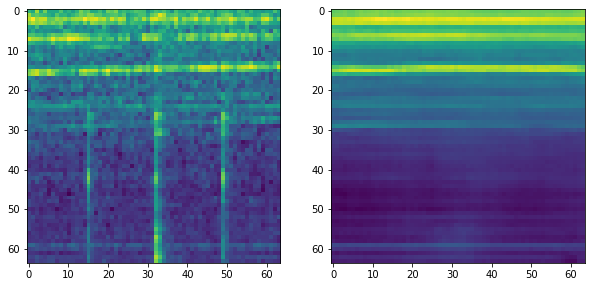

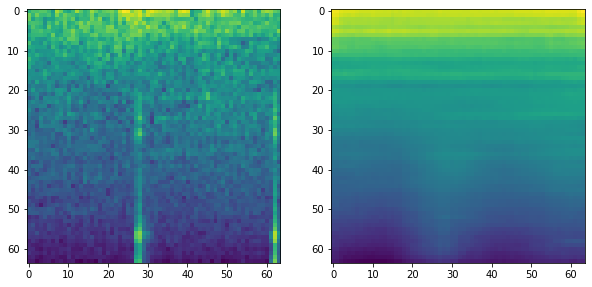

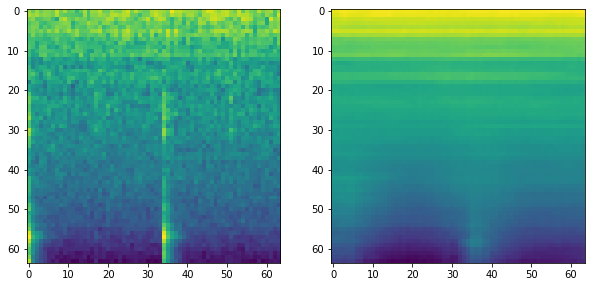

In [8]:
show_some_predictions(task2.train_dataloader(), task2.model, 0, 3, image=True)

(256, 64, 64) (256, 64, 64)


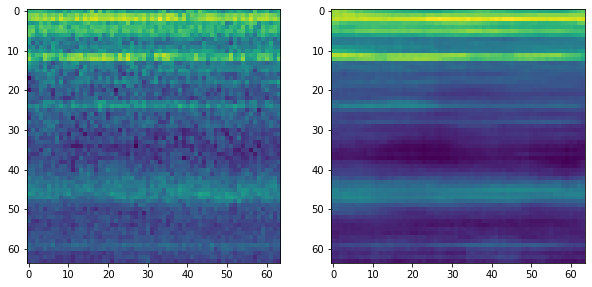

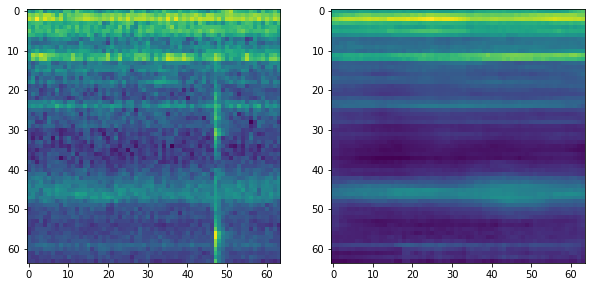

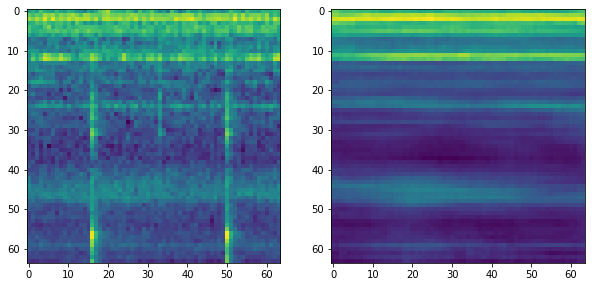

In [9]:
show_some_predictions(task2.val_dataloader(), task2.model, 0, 3, image=True)

## Test example with visualizations

2020-03-22 00:41:58,839 - INFO - load_directory <- development
2020-03-22 00:41:58,840 - INFO - loading model: ./model/model_ToyCar.pth
2020-03-22 00:41:58,974 - INFO - target_dir : ToyCar_id_01
2020-03-22 00:41:58,979 - INFO - test_file  num : 614
  0%|          | 0/614 [00:00<?, ?it/s]


[1/6] /home/dl/lab/task2/dcase2020_task2_variants/dev_data/ToyCar
============== MODEL LOAD ==============
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 1, 131, 131]               0
            Conv2d-2           [-1, 32, 64, 64]             832
              ReLU-3           [-1, 32, 64, 64]               0
         ZeroPad2d-4           [-1, 32, 67, 67]               0
            Conv2d-5           [-1, 64, 32, 32]          51,264
              ReLU-6           [-1, 64, 32, 32]               0
           Dropout-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 15, 15]          73,856
              ReLU-9          [-1, 128, 15, 15]               0
          Dropout-10          [-1, 128, 15, 15]               0
           Conv2d-11            [-1, 256, 7, 7]         295,168
             ReLU-12            [-1, 256, 7, 7]            

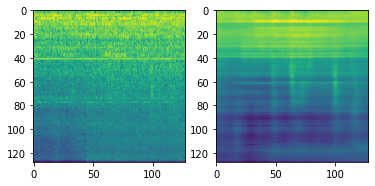

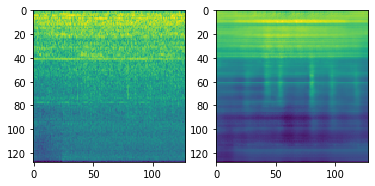

 81%|████████  | 496/614 [00:03<00:00, 142.51it/s]

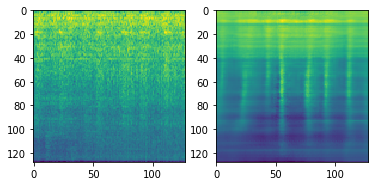

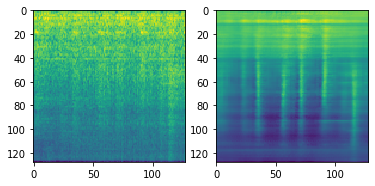

100%|██████████| 614/614 [00:04<00:00, 125.38it/s]
2020-03-22 00:42:03,882 - INFO - AUC : 0.6093831168831169
2020-03-22 00:42:03,882 - INFO - pAUC : 0.5496126680337207
2020-03-22 00:42:03,883 - INFO - target_dir : ToyCar_id_02
2020-03-22 00:42:03,888 - INFO - test_file  num : 615
  0%|          | 0/615 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


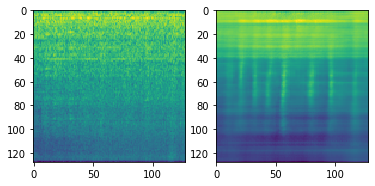

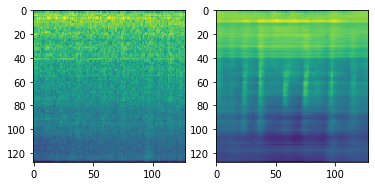

 80%|████████  | 495/615 [00:03<00:00, 142.45it/s]

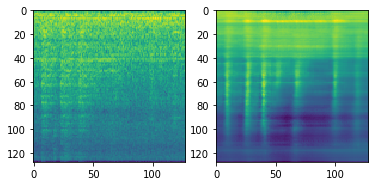

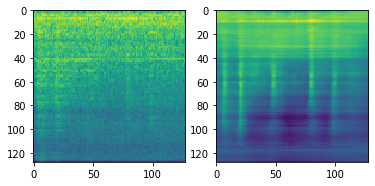

100%|██████████| 615/615 [00:04<00:00, 126.42it/s]
2020-03-22 00:42:08,756 - INFO - AUC : 0.7223719676549865
2020-03-22 00:42:08,757 - INFO - pAUC : 0.6547595403603348
2020-03-22 00:42:08,757 - INFO - target_dir : ToyCar_id_03
2020-03-22 00:42:08,762 - INFO - test_file  num : 615
  0%|          | 0/615 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


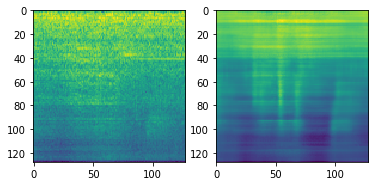

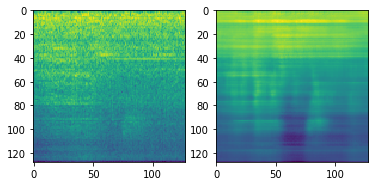

 80%|████████  | 495/615 [00:03<00:00, 142.11it/s]

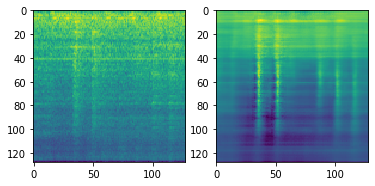

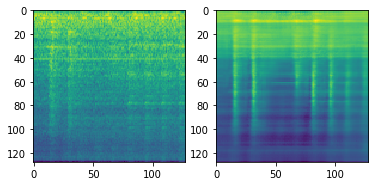

100%|██████████| 615/615 [00:04<00:00, 126.18it/s]
2020-03-22 00:42:13,640 - INFO - AUC : 0.7125606469002695
2020-03-22 00:42:13,640 - INFO - pAUC : 0.6114058731734998
2020-03-22 00:42:13,641 - INFO - target_dir : ToyCar_id_04
2020-03-22 00:42:13,647 - INFO - test_file  num : 615
  0%|          | 0/615 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


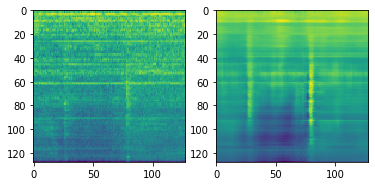

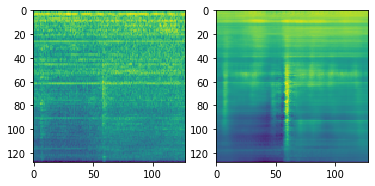

 80%|███████▉  | 491/615 [00:03<00:00, 142.07it/s]

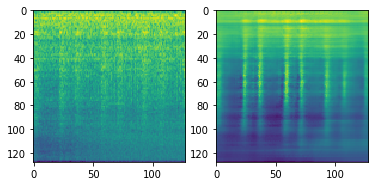

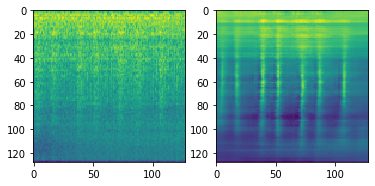

100%|██████████| 615/615 [00:04<00:00, 125.02it/s]
2020-03-22 00:42:18,570 - INFO - AUC : 0.8010134770889488
2020-03-22 00:42:18,570 - INFO - pAUC : 0.6885799404170805
2020-03-22 00:42:18,571 - INFO - loading model: ./model/model_ToyConveyor.pth
2020-03-22 00:42:18,593 - INFO - target_dir : ToyConveyor_id_01
2020-03-22 00:42:18,600 - INFO - test_file  num : 1200
  0%|          | 0/1200 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============

[2/6] /home/dl/lab/task2/dcase2020_task2_variants/dev_data/ToyConveyor
============== MODEL LOAD ==============
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 1, 131, 131]               0
            Conv2d-2           [-1, 32, 64, 64]             832
              ReLU-3           [-1, 32, 64, 64]               0
         ZeroPad2d-4           [-1, 32, 67, 67]               0
            Conv2d-5           [-1, 64, 32, 32]          51,264
              ReLU-6           [-1, 64, 32, 32]               0
           Dropout-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 15, 15]          73,856
              ReLU-9          [-1, 128, 15, 15]               0
          Dropout-10          [-1, 128, 15, 15]               0
           Conv2d-11            [-1, 256, 7, 7]         295,16

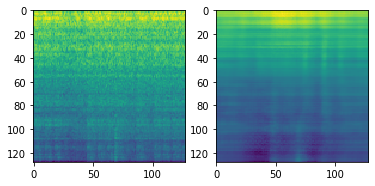

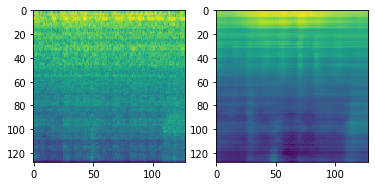

 41%|████▏     | 496/1200 [00:03<00:06, 113.28it/s]

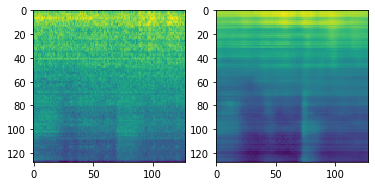

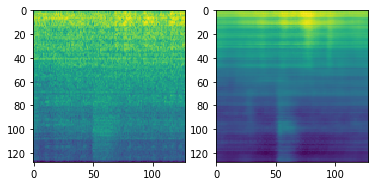

100%|██████████| 1200/1200 [00:08<00:00, 137.02it/s]
2020-03-22 00:42:27,362 - INFO - AUC : 0.45238125
2020-03-22 00:42:27,362 - INFO - pAUC : 0.49154605263157897
2020-03-22 00:42:27,362 - INFO - target_dir : ToyConveyor_id_02
2020-03-22 00:42:27,370 - INFO - test_file  num : 1155
  0%|          | 0/1155 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


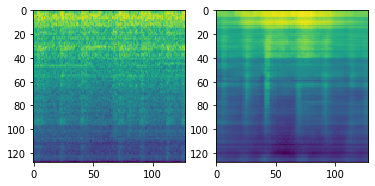

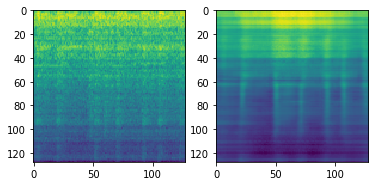

 43%|████▎     | 496/1155 [00:03<00:04, 148.11it/s]

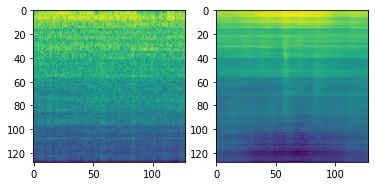

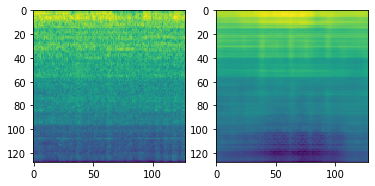

100%|██████████| 1155/1155 [00:08<00:00, 138.19it/s]
2020-03-22 00:42:35,732 - INFO - AUC : 0.47423239436619713
2020-03-22 00:42:35,732 - INFO - pAUC : 0.49872127501853225
2020-03-22 00:42:35,733 - INFO - target_dir : ToyConveyor_id_03
2020-03-22 00:42:35,740 - INFO - test_file  num : 1154
  0%|          | 0/1154 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


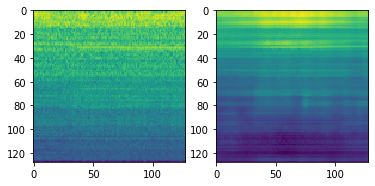

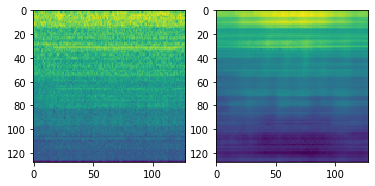

 43%|████▎     | 496/1154 [00:03<00:04, 148.08it/s]

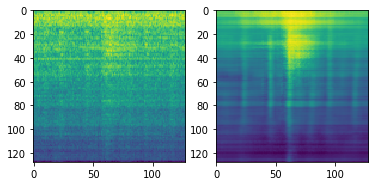

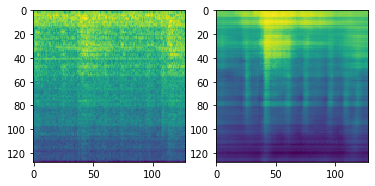

100%|██████████| 1154/1154 [00:08<00:00, 138.32it/s]
2020-03-22 00:42:44,087 - INFO - AUC : 0.5408944278940224
2020-03-22 00:42:44,087 - INFO - pAUC : 0.5251403023237906
2020-03-22 00:42:44,088 - INFO - loading model: ./model/model_fan.pth
2020-03-22 00:42:44,106 - INFO - target_dir : fan_id_00
2020-03-22 00:42:44,110 - INFO - test_file  num : 507
  0%|          | 0/507 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============

[3/6] /home/dl/lab/task2/dcase2020_task2_variants/dev_data/fan
============== MODEL LOAD ==============
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 1, 131, 131]               0
            Conv2d-2           [-1, 32, 64, 64]             832
              ReLU-3           [-1, 32, 64, 64]               0
         ZeroPad2d-4           [-1, 32, 67, 67]               0
            Conv2d-5           [-1, 64, 32, 32]          51,264
              ReLU-6           [-1, 64, 32, 32]               0
           Dropout-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 15, 15]          73,856
              ReLU-9          [-1, 128, 15, 15]               0
          Dropout-10          [-1, 128, 15, 15]               0
           Conv2d-11            [-1, 256, 7, 7]         295,168
      

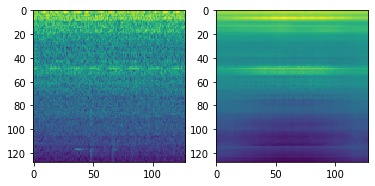

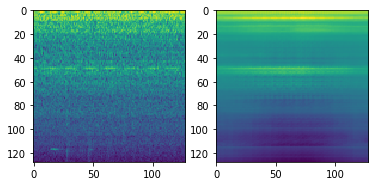

 96%|█████████▌| 487/507 [00:03<00:00, 138.46it/s]

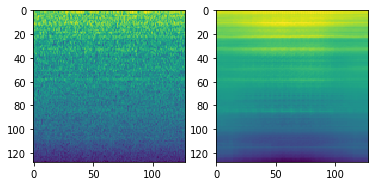

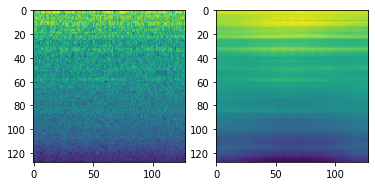

100%|██████████| 507/507 [00:04<00:00, 121.58it/s]
2020-03-22 00:42:48,283 - INFO - AUC : 0.47287469287469286
2020-03-22 00:42:48,283 - INFO - pAUC : 0.49890081469028835
2020-03-22 00:42:48,284 - INFO - target_dir : fan_id_02
2020-03-22 00:42:48,288 - INFO - test_file  num : 459
  0%|          | 0/459 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


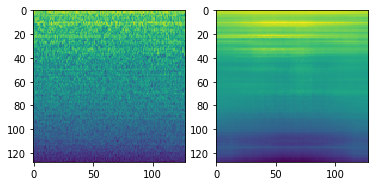

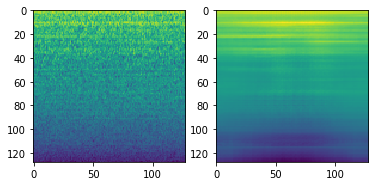

100%|██████████| 459/459 [00:03<00:00, 136.66it/s]
2020-03-22 00:42:51,650 - INFO - AUC : 0.47376044568245124
2020-03-22 00:42:51,650 - INFO - pAUC : 0.52353027415335
2020-03-22 00:42:51,651 - INFO - target_dir : fan_id_04
2020-03-22 00:42:51,654 - INFO - test_file  num : 448
  0%|          | 0/448 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


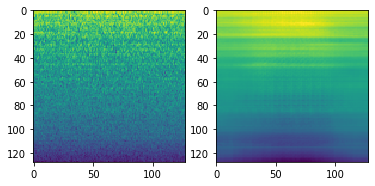

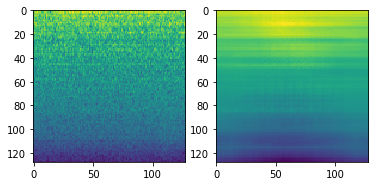

100%|██████████| 448/448 [00:03<00:00, 136.66it/s]
2020-03-22 00:42:54,936 - INFO - AUC : 0.4497988505747127
2020-03-22 00:42:54,936 - INFO - pAUC : 0.5069570477918935
2020-03-22 00:42:54,936 - INFO - target_dir : fan_id_06
2020-03-22 00:42:54,941 - INFO - test_file  num : 461
  0%|          | 0/461 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


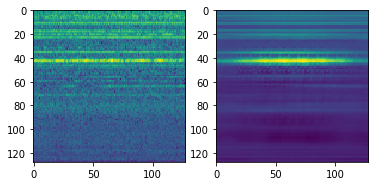

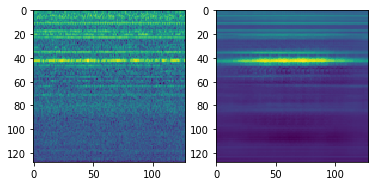

100%|██████████| 461/461 [00:03<00:00, 135.71it/s]
2020-03-22 00:42:58,341 - INFO - AUC : 0.48326869806094186
2020-03-22 00:42:58,341 - INFO - pAUC : 0.5077999708412305
2020-03-22 00:42:58,342 - INFO - loading model: ./model/model_pump.pth
2020-03-22 00:42:58,358 - INFO - target_dir : pump_id_00
2020-03-22 00:42:58,360 - INFO - test_file  num : 243
  0%|          | 0/243 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============

[4/6] /home/dl/lab/task2/dcase2020_task2_variants/dev_data/pump
============== MODEL LOAD ==============
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 1, 131, 131]               0
            Conv2d-2           [-1, 32, 64, 64]             832
              ReLU-3           [-1, 32, 64, 64]               0
         ZeroPad2d-4           [-1, 32, 67, 67]               0
            Conv2d-5           [-1, 64, 32, 32]          51,264
              ReLU-6           [-1, 64, 32, 32]               0
           Dropout-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 15, 15]          73,856
              ReLU-9          [-1, 128, 15, 15]               0
          Dropout-10          [-1, 128, 15, 15]               0
           Conv2d-11            [-1, 256, 7, 7]         295,168
     

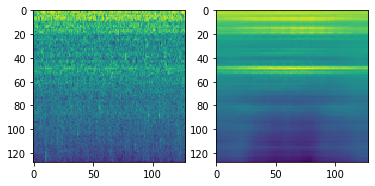

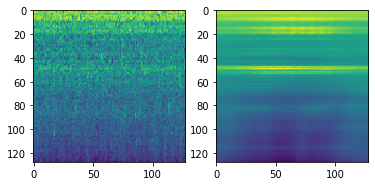

100%|██████████| 243/243 [00:01<00:00, 128.13it/s]
2020-03-22 00:43:00,259 - INFO - AUC : 0.5925174825174825
2020-03-22 00:43:00,260 - INFO - pAUC : 0.5263157894736842
2020-03-22 00:43:00,260 - INFO - target_dir : pump_id_02
2020-03-22 00:43:00,263 - INFO - test_file  num : 211
  0%|          | 0/211 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


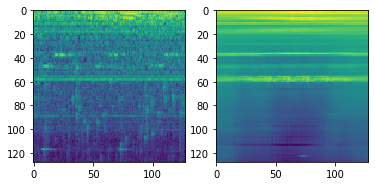

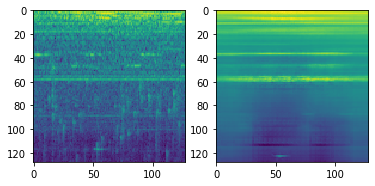

100%|██████████| 211/211 [00:01<00:00, 114.81it/s]
2020-03-22 00:43:02,104 - INFO - AUC : 0.5193693693693694
2020-03-22 00:43:02,104 - INFO - pAUC : 0.4874348032242769
2020-03-22 00:43:02,104 - INFO - target_dir : pump_id_04
2020-03-22 00:43:02,107 - INFO - test_file  num : 200
  0%|          | 0/200 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


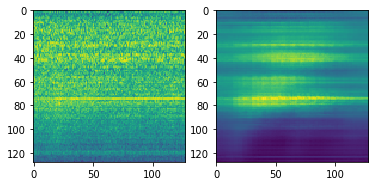

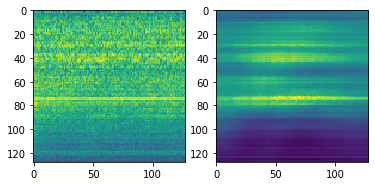

100%|██████████| 200/200 [00:01<00:00, 122.18it/s]
2020-03-22 00:43:03,747 - INFO - AUC : 0.4208
2020-03-22 00:43:03,747 - INFO - pAUC : 0.49105263157894735
2020-03-22 00:43:03,747 - INFO - target_dir : pump_id_06
2020-03-22 00:43:03,750 - INFO - test_file  num : 202
  0%|          | 0/202 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


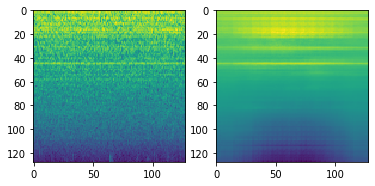

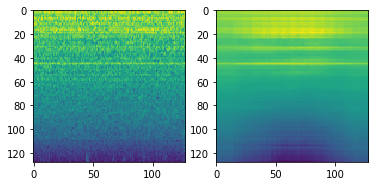

100%|██████████| 202/202 [00:01<00:00, 123.22it/s]
2020-03-22 00:43:05,393 - INFO - AUC : 0.31098039215686274
2020-03-22 00:43:05,393 - INFO - pAUC : 0.4809081527347781
2020-03-22 00:43:05,394 - INFO - loading model: ./model/model_slider.pth
2020-03-22 00:43:05,412 - INFO - target_dir : slider_id_00
2020-03-22 00:43:05,415 - INFO - test_file  num : 456
  0%|          | 0/456 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============

[5/6] /home/dl/lab/task2/dcase2020_task2_variants/dev_data/slider
============== MODEL LOAD ==============
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 1, 131, 131]               0
            Conv2d-2           [-1, 32, 64, 64]             832
              ReLU-3           [-1, 32, 64, 64]               0
         ZeroPad2d-4           [-1, 32, 67, 67]               0
            Conv2d-5           [-1, 64, 32, 32]          51,264
              ReLU-6           [-1, 64, 32, 32]               0
           Dropout-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 15, 15]          73,856
              ReLU-9          [-1, 128, 15, 15]               0
          Dropout-10          [-1, 128, 15, 15]               0
           Conv2d-11            [-1, 256, 7, 7]         295,168
   

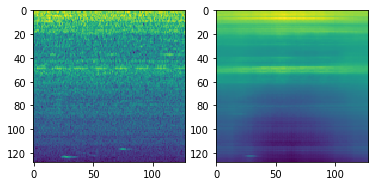

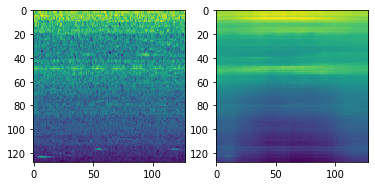

100%|██████████| 456/456 [00:03<00:00, 138.12it/s]
2020-03-22 00:43:08,720 - INFO - AUC : 0.41558988764044946
2020-03-22 00:43:08,720 - INFO - pAUC : 0.47368421052631576
2020-03-22 00:43:08,720 - INFO - target_dir : slider_id_02
2020-03-22 00:43:08,724 - INFO - test_file  num : 367
  0%|          | 0/367 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


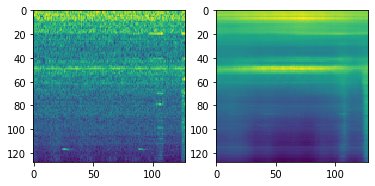

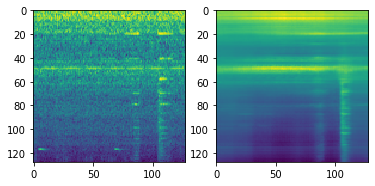

100%|██████████| 367/367 [00:02<00:00, 134.87it/s]
2020-03-22 00:43:11,448 - INFO - AUC : 0.3441573033707864
2020-03-22 00:43:11,449 - INFO - pAUC : 0.47959787108219987
2020-03-22 00:43:11,449 - INFO - target_dir : slider_id_04
2020-03-22 00:43:11,452 - INFO - test_file  num : 278
  0%|          | 0/278 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


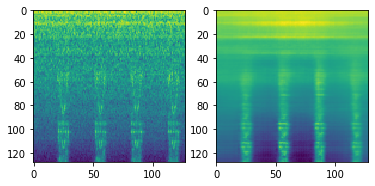

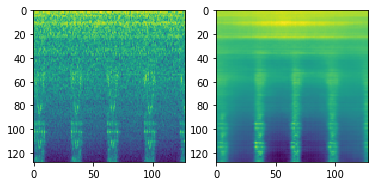

100%|██████████| 278/278 [00:02<00:00, 135.15it/s]
2020-03-22 00:43:13,512 - INFO - AUC : 0.5194943820224719
2020-03-22 00:43:13,512 - INFO - pAUC : 0.513010053222945
2020-03-22 00:43:13,513 - INFO - target_dir : slider_id_06
2020-03-22 00:43:13,515 - INFO - test_file  num : 189
  0%|          | 0/189 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


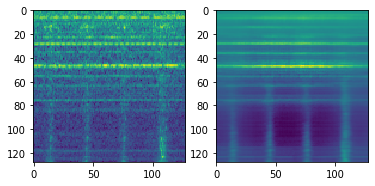

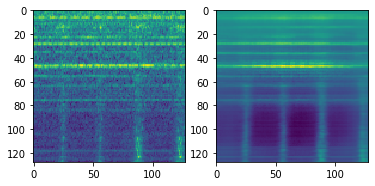

100%|██████████| 189/189 [00:01<00:00, 129.97it/s]
2020-03-22 00:43:14,972 - INFO - AUC : 0.48831460674157307
2020-03-22 00:43:14,973 - INFO - pAUC : 0.48492016558249557
2020-03-22 00:43:14,973 - INFO - loading model: ./model/model_valve.pth
2020-03-22 00:43:14,990 - INFO - target_dir : valve_id_00
2020-03-22 00:43:14,992 - INFO - test_file  num : 219
  0%|          | 0/219 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============

[6/6] /home/dl/lab/task2/dcase2020_task2_variants/dev_data/valve
============== MODEL LOAD ==============
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 1, 131, 131]               0
            Conv2d-2           [-1, 32, 64, 64]             832
              ReLU-3           [-1, 32, 64, 64]               0
         ZeroPad2d-4           [-1, 32, 67, 67]               0
            Conv2d-5           [-1, 64, 32, 32]          51,264
              ReLU-6           [-1, 64, 32, 32]               0
           Dropout-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 15, 15]          73,856
              ReLU-9          [-1, 128, 15, 15]               0
          Dropout-10          [-1, 128, 15, 15]               0
           Conv2d-11            [-1, 256, 7, 7]         295,168
    

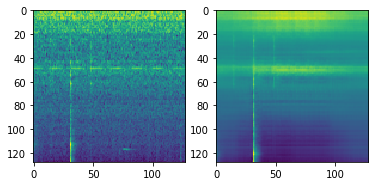

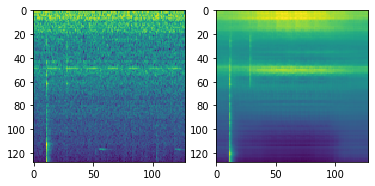

100%|██████████| 219/219 [00:01<00:00, 124.52it/s]
2020-03-22 00:43:16,753 - INFO - AUC : 0.42126050420168065
2020-03-22 00:43:16,754 - INFO - pAUC : 0.5002211410880142
2020-03-22 00:43:16,754 - INFO - target_dir : valve_id_02
2020-03-22 00:43:16,756 - INFO - test_file  num : 220
  0%|          | 0/220 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


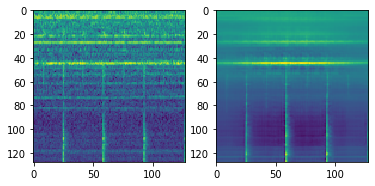

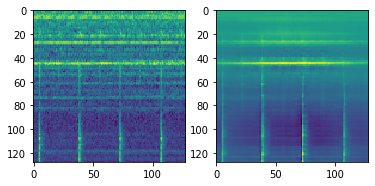

100%|██████████| 220/220 [00:01<00:00, 124.48it/s]
2020-03-22 00:43:18,526 - INFO - AUC : 0.5285
2020-03-22 00:43:18,527 - INFO - pAUC : 0.5074561403508772
2020-03-22 00:43:18,527 - INFO - target_dir : valve_id_04
2020-03-22 00:43:18,529 - INFO - test_file  num : 220
  0%|          | 0/220 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


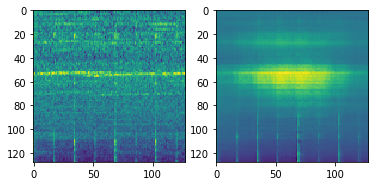

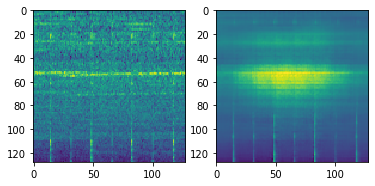

100%|██████████| 220/220 [00:01<00:00, 124.92it/s]
2020-03-22 00:43:20,293 - INFO - AUC : 0.5439166666666667
2020-03-22 00:43:20,293 - INFO - pAUC : 0.5026315789473684
2020-03-22 00:43:20,294 - INFO - target_dir : valve_id_06
2020-03-22 00:43:20,296 - INFO - test_file  num : 220
  0%|          | 0/220 [00:00<?, ?it/s]


============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


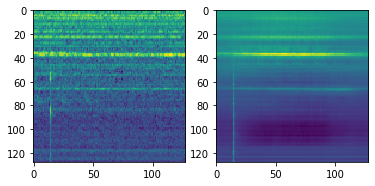

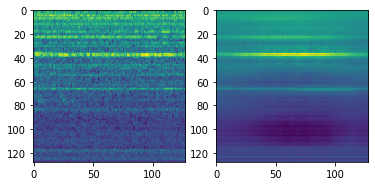

100%|██████████| 220/220 [00:01<00:00, 124.72it/s]
2020-03-22 00:43:22,062 - INFO - AUC : 0.377
2020-03-22 00:43:22,063 - INFO - pAUC : 0.48596491228070177



============ END OF TEST FOR A MACHINE ID ============


In [10]:
import glob
import re
import itertools
from tqdm import tqdm
from sklearn import metrics

########################################################################
# control stochastic behavior
########################################################################
deterministic_everything(2022, pytorch=True)
#######################################################################


########################################################################
# def
########################################################################
def save_csv(save_file_path,
             save_data):
    with open(save_file_path, "w", newline="") as f:
        writer = csv.writer(f, lineterminator='\n')
        writer.writerows(save_data)


def get_machine_id_list_for_test(target_dir,
                                 dir_name="test",
                                 ext="wav"):
    """
    target_dir : str
        base directory path of "dev_data" or "eval_data"
    test_dir_name : str (default="test")
        directory containing test data
    ext : str (default="wav)
        file extension of audio files

    return :
        machine_id_list : list [ str ]
            list of machine IDs extracted from the names of test files
    """
    # create test files
    dir_path = os.path.abspath("{dir}/{dir_name}/*.{ext}".format(dir=target_dir, dir_name=dir_name, ext=ext))
    file_paths = sorted(glob.glob(dir_path))
    # extract id
    machine_id_list = sorted(list(set(itertools.chain.from_iterable(
        [re.findall('id_[0-9][0-9]', ext_id) for ext_id in file_paths]))))
    return machine_id_list


def test_file_list_generator(target_dir,
                             id_name,
                             dir_name="test",
                             prefix_normal="normal",
                             prefix_anomaly="anomaly",
                             ext="wav"):
    """
    target_dir : str
        base directory path of the dev_data or eval_data
    id_name : str
        id of wav file in <<test_dir_name>> directory
    dir_name : str (default="test")
        directory containing test data
    prefix_normal : str (default="normal")
        normal directory name
    prefix_anomaly : str (default="anomaly")
        anomaly directory name
    ext : str (default="wav")
        file extension of audio files

    return :
        if the mode is "development":
            test_files : list [ str ]
                file list for test
            test_labels : list [ boolean ]
                label info. list for test
                * normal/anomaly = 0/1
        if the mode is "evaluation":
            test_files : list [ str ]
                file list for test
    """
    com.logger.info("target_dir : {}".format(Path(target_dir+"_"+id_name).name))

    # development
    if mode:
        normal_files = sorted(
            glob.glob("{dir}/{dir_name}/{prefix_normal}_{id_name}*.{ext}".format(dir=target_dir,
                                                                                 dir_name=dir_name,
                                                                                 prefix_normal=prefix_normal,
                                                                                 id_name=id_name,
                                                                                 ext=ext)))
        normal_labels = np.zeros(len(normal_files))
        anomaly_files = sorted(
            glob.glob("{dir}/{dir_name}/{prefix_anomaly}_{id_name}*.{ext}".format(dir=target_dir,
                                                                                  dir_name=dir_name,
                                                                                  prefix_anomaly=prefix_anomaly,
                                                                                  id_name=id_name,
                                                                                  ext=ext)))
        anomaly_labels = np.ones(len(anomaly_files))
        files = np.concatenate((normal_files, anomaly_files), axis=0)
        labels = np.concatenate((normal_labels, anomaly_labels), axis=0)
        com.logger.info("test_file  num : {num}".format(num=len(files)))
        if len(files) == 0:
            com.logger.exception("no_wav_file!!")
        print("\n========================================")

    # evaluation
    else:
        files = sorted(
            glob.glob("{dir}/{dir_name}/*{id_name}*.{ext}".format(dir=target_dir,
                                                                  dir_name=dir_name,
                                                                  id_name=id_name,
                                                                  ext=ext)))
        labels = None
        com.logger.info("test_file  num : {num}".format(num=len(files)))
        if len(files) == 0:
            com.logger.exception("no_wav_file!!")
        print("\n=========================================")

    return files, labels
########################################################################


########################################################################
# main 01_test.py
########################################################################
if True:
    # check mode
    # "development": mode == True
    # "evaluation": mode == False
    mode = com.command_line_chk(args=['-d'])
    if mode is None:
        sys.exit(-1)

    # make output result directory
    os.makedirs(params.result_directory, exist_ok=True)

    # load base directory
    dirs = com.select_dirs(param=params, mode=mode)

    # initialize lines in csv for AUC and pAUC
    csv_lines = []

    # PyTorch version specific...
    to_tensor = ToTensor1ch(image=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # loop of the base directory
    for idx, target_dir in enumerate(dirs):
        print("\n===========================")
        print("[{idx}/{total}] {dirname}".format(dirname=target_dir, idx=idx+1, total=len(dirs)))
        machine_type = os.path.split(target_dir)[1]

        print("============== MODEL LOAD ==============")
        # set model path
        model_file = "{model}/model_{machine_type}.pth".format(model=params.model_directory,
                                                               machine_type=machine_type)

        # load model file
        if not os.path.exists(model_file):
            com.logger.error("{} model not found ".format(machine_type))
            sys.exit(-1)
        com.logger.info("loading model: {}".format(model_file))
        model = CNNAutoEncoder().to(device)
        load_weights(model, model_file)
        summary(device, model, input_size=(1, params.feature.n_mels, params.feature.n_mels))
        model.eval()

        if mode:
            # results by type
            csv_lines.append([machine_type])
            csv_lines.append(["id", "AUC", "pAUC"])
            performance = []

        machine_id_list = get_machine_id_list_for_test(target_dir)

        for id_str in machine_id_list:
            # load test file
            test_files, y_true = test_file_list_generator(target_dir, id_str)

            # setup anomaly score file path
            anomaly_score_csv = "{result}/anomaly_score_{machine_type}_{id_str}.csv".format(
                                                                                     result=params.result_directory,
                                                                                     machine_type=machine_type,
                                                                                     id_str=id_str)
            anomaly_score_list = []

            print("\n============== BEGIN TEST FOR A MACHINE ID ==============")
            y_pred = [0. for k in test_files]
            for file_idx, file_path in tqdm(enumerate(test_files), total=len(test_files)):
                if True:# try:
                    data = file_to_vector_array_2d(file_path,
                                                    n_mels=params.feature.n_mels,
                                                    n_fft=params.feature.n_fft,
                                                    hop_length=params.feature.hop_length,
                                                    power=params.feature.power)
                    data = normalize_0to1(data)
                    with torch.no_grad():
                        yhat = model(to_tensor(data)).cpu().detach().numpy().reshape(data.shape)
                        errors = np.mean(np.square(data - yhat), axis=1)
                        if file_idx in [0, 500]:
                            for i in range(2):
                                fig, axs = plt.subplots(1, 2)
                                axs[0].imshow(data[i])
                                axs[1].imshow(yhat[i])
                                plt.show()
                    y_pred[file_idx] = np.mean(errors)
                    anomaly_score_list.append([os.path.basename(file_path), y_pred[file_idx]])


            # save anomaly score
            #save_csv(save_file_path=anomaly_score_csv, save_data=anomaly_score_list)
            #com.logger.info("anomaly score result ->  {}".format(anomaly_score_csv))

            if mode:
                # append AUC and pAUC to lists
                auc = metrics.roc_auc_score(y_true, y_pred)
                p_auc = metrics.roc_auc_score(y_true, y_pred, max_fpr=params.max_fpr)
                csv_lines.append([id_str.split("_", 1)[1], auc, p_auc])
                performance.append([auc, p_auc])
                com.logger.info("AUC : {}".format(auc))
                com.logger.info("pAUC : {}".format(p_auc))

            print("\n============ END OF TEST FOR A MACHINE ID ============")

        if mode:
            # calculate averages for AUCs and pAUCs
            averaged_performance = np.mean(np.array(performance, dtype=float), axis=0)
            csv_lines.append(["Average"] + list(averaged_performance))
            csv_lines.append([])


In [11]:
csv_lines

[['ToyCar'],
 ['id', 'AUC', 'pAUC'],
 ['01', 0.6093831168831169, 0.5496126680337207],
 ['02', 0.7223719676549865, 0.6547595403603348],
 ['03', 0.7125606469002695, 0.6114058731734998],
 ['04', 0.8010134770889488, 0.6885799404170805],
 ['Average', 0.7113323021318305, 0.6260895054961589],
 [],
 ['ToyConveyor'],
 ['id', 'AUC', 'pAUC'],
 ['01', 0.45238125, 0.49154605263157897],
 ['02', 0.47423239436619713, 0.49872127501853225],
 ['03', 0.5408944278940224, 0.5251403023237906],
 ['Average', 0.4891693574200732, 0.5051358766579673],
 [],
 ['fan'],
 ['id', 'AUC', 'pAUC'],
 ['00', 0.47287469287469286, 0.49890081469028835],
 ['02', 0.47376044568245124, 0.52353027415335],
 ['04', 0.4497988505747127, 0.5069570477918935],
 ['06', 0.48326869806094186, 0.5077999708412305],
 ['Average', 0.46992567179819966, 0.5092970268691905],
 [],
 ['pump'],
 ['id', 'AUC', 'pAUC'],
 ['00', 0.5925174825174825, 0.5263157894736842],
 ['02', 0.5193693693693694, 0.4874348032242769],
 ['04', 0.4208, 0.49105263157894735],
 [